In [3]:
from Preprocessing.data_clean import get_data, dropping_no_betting_data
from sklearn.preprocessing import MinMaxScaler
from sklearn import set_config
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout 
from keras.utils import get_custom_objects
import pandas as pd
import numpy as np
import pickle
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Getting the data and filling the missing odds

In [3]:
data = get_data("../raw_data/hr_data_0409_221rem.csv") ###receiving all columns of data for user selected rows (by track and time)
data = dropping_no_betting_data(data)
data = data[(data['f_pm_05m'] <= 50)]
data = data.reset_index(drop=True)

data acquired with shape (120675, 116)
Cleaned up missing odds. New shape = (120414, 116)


## Filling the null L16 columns with 0

In [4]:
X_preproc = data[[
          'iv_trainer_l16r', 'iv_jockey_l16r',
          'ae_trainer_l16r' ,'ae_jockey_l16r']]
X_preproc = X_preproc.fillna(0)

In [5]:
X_preproc.isna().sum()

iv_trainer_l16r    0
iv_jockey_l16r     0
ae_trainer_l16r    0
ae_jockey_l16r     0
dtype: int64

## Scaling the numerical values and defining X

In [6]:
### 1. Add f_runners to the 4 imputed columns
### 2. Scale those 5 columns using loaded weights
### 3. Add stall_position and pred_isp to imputed / scaled columns

In [7]:
X_preproc['f_runners'] = data['f_runners']

In [8]:
# Scale features
set_config(transform_output = "pandas")
with open('../Models/JS_weights/scaler_josh.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
X = loaded_scaler.transform(X_preproc)

In [9]:
X['pred_isp_prob'] = 1 / data['pred_isp']
X['stall_position'] = data['stall_position']

In [10]:
X.head(2)

,iv_trainer_l16r,iv_jockey_l16r,ae_trainer_l16r,ae_jockey_l16r,f_runners,pred_isp_prob,stall_position
0,0.0,0.5,0.0,0.014018,0.15625,0.400000,0.2857
1,0.0,0.0,0.0,0.000000,0.15625,0.076923,0.7143


In [11]:
X.shape

(106988, 7)

In [12]:
X.tail(20)

,iv_trainer_l16r,iv_jockey_l16r,ae_trainer_l16r,ae_jockey_l16r,f_runners,pred_isp_prob,stall_position
106968,0.062887,0.062887,0.010379,0.006622,0.4375,0.133333,0.7500
106969,0.000000,0.124742,0.000000,0.021758,0.4375,0.058824,1.0000
106970,0.124742,0.062887,0.013375,0.006278,0.4375,0.038462,0.1250
106971,0.000000,0.249485,0.000000,0.022876,0.5000,0.058824,0.0556
106972,0.124742,0.000000,0.020330,0.000000,0.5000,0.066667,0.2222
106973,0.062887,0.000000,0.010807,0.000000,0.5000,0.058824,0.1667
106974,0.062887,0.000000,0.008239,0.000000,0.5000,0.058824,0.1111
106975,0.124742,0.124742,0.023004,0.009976,0.5000,0.181818,0.2778
106976,0.000000,0.062887,0.000000,0.007310,0.5000,0.111111,1.0556
106977,0.000000,0.000000,0.000000,0.000000,0.5000,0.076923,0.5000


In [13]:
X_test = X.iloc[106971:]
X_test.shape

(17, 7)

## Defining y

In [14]:
def winner(x):
        if x == 1:
            return 1
        else:
            return 0
data['f_place'] = data['f_place'].apply(winner)

In [15]:
y = data[['f_place', 'pred_isp']]

In [16]:
y.head(2)

,f_place,pred_isp
0,0,2.5
1,0,13.0


In [17]:
y.shape

(106988, 2)

In [18]:
y_test = y.iloc[106971:]

In [19]:
y_test.shape

(17, 2)

## Defining backtest and changing commision to 2%

In [20]:
# Define a lambda function to apply the conditions and fill NaN values
def fill_01m_profit(data):
    def fill_nan(row):
        if row['f_place'] == 0:
            return -1
        elif row['f_place'] == 1:
            return (row['f_pm_01m'] - 1) * 0.98
        else:
            return row['f_pm_01m_p_back']

# Apply the lambda function to fill NaN values in f_pm_01m_p_back
    data['01m_profit'] = data.apply(fill_nan, axis=1)
    return data

data = fill_01m_profit(data)

In [21]:
backtest = data[['f_ko', 'f_track', 'f_id', 'id','f_horse','f_pm_01m', '01m_profit', 'f_place']]

In [22]:
backtest.tail(20)

,f_ko,f_track,f_id,id,f_horse,f_pm_01m,01m_profit,f_place
106968,03/09/2023 16:55,TIPPERARY,1.693760e+13,1.693760e+13,Silkies Sib,7.2,6.076,1
106969,03/09/2023 16:55,TIPPERARY,1.693760e+13,1.693760e+13,Below Deck,27.0,-1.000,0
106970,03/09/2023 16:55,TIPPERARY,1.693760e+13,1.693760e+13,Ruler Of The River,65.0,-1.000,0
106971,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Humtaza,13.0,-1.000,0
106972,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Rock On Seamie,28.0,-1.000,0
106973,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Cleopatras Needle,20.0,-1.000,0
106974,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Sil Ver Klass,30.0,-1.000,0
106975,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,French Company,14.5,-1.000,0
106976,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Rain,15.5,-1.000,0
106977,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Butterfly Garden,25.0,-1.000,0


In [23]:
backtest_test = backtest.iloc[106971:]

In [24]:
backtest_test.shape

(17, 8)

In [25]:
backtest_test

,f_ko,f_track,f_id,id,f_horse,f_pm_01m,01m_profit,f_place
106971,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Humtaza,13.0,-1.00,0
106972,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Rock On Seamie,28.0,-1.00,0
106973,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Cleopatras Needle,20.0,-1.00,0
106974,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Sil Ver Klass,30.0,-1.00,0
106975,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,French Company,14.5,-1.00,0
106976,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Rain,15.5,-1.00,0
106977,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Butterfly Garden,25.0,-1.00,0
106978,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Firm Belief,12.5,-1.00,0
106979,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Indignation,12.5,-1.00,0
106980,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Lispendense,14.0,-1.00,0


## Model Architecture

In [26]:
# def custom_loss_function(y_true, y_pred):
#     y_true = tf.cast(y_true, dtype=tf.float32)  # Convert y_true to float32
#     y_pred = tf.cast(y_pred, dtype=tf.float32)
    
#     win_horse = y_true[:, 0:1]
#     win_odds = y_true[:, 1:2]
#     gain_loss_vector = K.concatenate([win_horse * (win_odds - 1) + (1 - win_horse) * -1,
#     K.zeros_like(win_odds)], axis=1)
#     return -0.1 * K.mean(K.sum(gain_loss_vector * y_pred, axis=1))
#     #return -1 * tf.reduce_mean(tf.reduce_sum(gain_loss_vector * y_pred, axis=1))

# get_custom_objects().update({"custom_loss_function": custom_loss_function})

In [27]:
NN = Sequential()
NN.add(InputLayer(input_shape=(7, ))) # input layer
NN.add(Dense(32, activation='relu')) # hidden layer 1
NN.add(Dense(2, activation='softmax')) # output layer

## Loading Weights

In [28]:
NN.load_weights("../Models/JS_weights/custom_scorer0.05_7input_l16_05mfilter_01mplace")

## Creating preds

1/1 [==============================] - 0s 29ms/step


<Axes: ylabel='Count'>

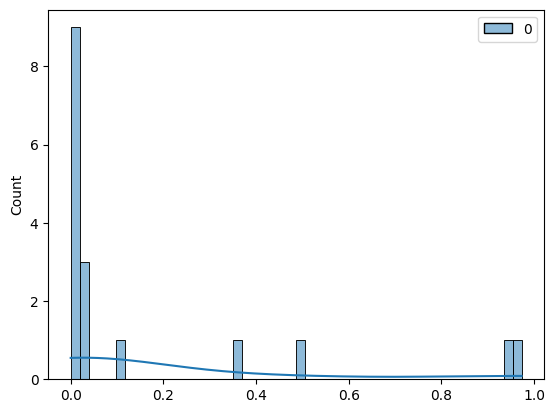

In [29]:
y_pred = NN.predict(X_test)
import seaborn as sns
sns.histplot(y_pred[:, 0:1], bins = 50, kde=True)

In [30]:
y_pred

array([[3.3584800e-02, 9.6641523e-01],
       [8.9327022e-03, 9.9106735e-01],
       [2.5861252e-02, 9.7413880e-01],
       [1.9060463e-02, 9.8093951e-01],
       [7.6985318e-10, 1.0000000e+00],
       [1.2321004e-03, 9.9876791e-01],
       [1.2756803e-02, 9.8724318e-01],
       [7.4051279e-03, 9.9259490e-01],
       [1.1610152e-01, 8.8389844e-01],
       [1.1721090e-02, 9.8827887e-01],
       [9.3890256e-01, 6.1097477e-02],
       [3.5536072e-01, 6.4463925e-01],
       [1.3037254e-06, 9.9999869e-01],
       [4.9931079e-01, 5.0068915e-01],
       [9.1790193e-04, 9.9908209e-01],
       [9.7319114e-01, 2.6808826e-02],
       [3.3361226e-02, 9.6663874e-01]], dtype=float32)

In [31]:
predictions = X_test

In [32]:
predictions['model_preds'] = y_pred[:, 0:1]
predictions['model_preds'] = round(predictions['model_preds'],2)
predictions.sort_values(['model_preds'], ascending = False)

,iv_trainer_l16r,iv_jockey_l16r,ae_trainer_l16r,ae_jockey_l16r,f_runners,pred_isp_prob,stall_position,model_preds
106986,0.312371,0.187629,0.058314,0.021758,0.5,0.038462,1.1111,0.97
106981,0.124742,0.124742,0.053285,0.012212,0.5,0.038462,0.7778,0.94
106984,0.124742,0.062887,0.019260,0.009116,0.5,0.066667,1.1667,0.50
106982,0.124742,0.124742,0.024288,0.009804,0.5,0.066667,1.0000,0.36
106979,0.062887,0.000000,0.012412,0.000000,0.5,0.066667,0.7222,0.12
106971,0.000000,0.249485,0.000000,0.022876,0.5,0.058824,0.0556,0.03
106973,0.062887,0.000000,0.010807,0.000000,0.5,0.058824,0.1667,0.03
106987,0.000000,0.062887,0.000000,0.004128,0.5,0.076923,0.6667,0.03
106974,0.062887,0.000000,0.008239,0.000000,0.5,0.058824,0.1111,0.02
106977,0.000000,0.000000,0.000000,0.000000,0.5,0.076923,0.5000,0.01


In [33]:
predictions

,iv_trainer_l16r,iv_jockey_l16r,ae_trainer_l16r,ae_jockey_l16r,f_runners,pred_isp_prob,stall_position,model_preds
106971,0.000000,0.249485,0.000000,0.022876,0.5,0.058824,0.0556,0.03
106972,0.124742,0.000000,0.020330,0.000000,0.5,0.066667,0.2222,0.01
106973,0.062887,0.000000,0.010807,0.000000,0.5,0.058824,0.1667,0.03
106974,0.062887,0.000000,0.008239,0.000000,0.5,0.058824,0.1111,0.02
106975,0.124742,0.124742,0.023004,0.009976,0.5,0.181818,0.2778,0.00
106976,0.000000,0.062887,0.000000,0.007310,0.5,0.111111,1.0556,0.00
106977,0.000000,0.000000,0.000000,0.000000,0.5,0.076923,0.5000,0.01
106978,0.062887,0.000000,0.009095,0.000000,0.5,0.076923,0.4444,0.01
106979,0.062887,0.000000,0.012412,0.000000,0.5,0.066667,0.7222,0.12
106980,0.000000,0.062887,0.000000,0.005246,0.5,0.090909,0.8889,0.01


In [34]:
y_pred

array([[3.3584800e-02, 9.6641523e-01],
       [8.9327022e-03, 9.9106735e-01],
       [2.5861252e-02, 9.7413880e-01],
       [1.9060463e-02, 9.8093951e-01],
       [7.6985318e-10, 1.0000000e+00],
       [1.2321004e-03, 9.9876791e-01],
       [1.2756803e-02, 9.8724318e-01],
       [7.4051279e-03, 9.9259490e-01],
       [1.1610152e-01, 8.8389844e-01],
       [1.1721090e-02, 9.8827887e-01],
       [9.3890256e-01, 6.1097477e-02],
       [3.5536072e-01, 6.4463925e-01],
       [1.3037254e-06, 9.9999869e-01],
       [4.9931079e-01, 5.0068915e-01],
       [9.1790193e-04, 9.9908209e-01],
       [9.7319114e-01, 2.6808826e-02],
       [3.3361226e-02, 9.6663874e-01]], dtype=float32)

In [35]:
backtest_test['model_preds'] = y_pred[:, 0:1]
backtest_test['model_preds'] = round(backtest_test['model_preds'],2)

In [36]:
backtest_test = backtest_test.sort_values(['model_preds'], ascending = False)
backtest_test

,f_ko,f_track,f_id,id,f_horse,f_pm_01m,01m_profit,f_place,model_preds
106986,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Rotolo,20.0,-1.00,0,0.97
106981,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Kingsofthemidlands,36.0,-1.00,0,0.94
106984,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Maralinga,34.0,32.34,1,0.50
106982,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Inchiquin Maid,12.0,-1.00,0,0.36
106979,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Indignation,12.5,-1.00,0,0.12
106971,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Humtaza,13.0,-1.00,0,0.03
106973,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Cleopatras Needle,20.0,-1.00,0,0.03
106987,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Kings Prince,12.0,-1.00,0,0.03
106974,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Sil Ver Klass,30.0,-1.00,0,0.02
106977,03/09/2023 17:30,TIPPERARY,1.693760e+13,1.693760e+13,Butterfly Garden,25.0,-1.00,0,0.01


In [37]:
backtest_live = backtest_test.drop(columns=['f_id', 'id', '01m_profit','f_place'])

In [38]:
backtest_live

,f_ko,f_track,f_horse,f_pm_01m,model_preds
106986,03/09/2023 17:30,TIPPERARY,Rotolo,20.0,0.97
106981,03/09/2023 17:30,TIPPERARY,Kingsofthemidlands,36.0,0.94
106984,03/09/2023 17:30,TIPPERARY,Maralinga,34.0,0.50
106982,03/09/2023 17:30,TIPPERARY,Inchiquin Maid,12.0,0.36
106979,03/09/2023 17:30,TIPPERARY,Indignation,12.5,0.12
106971,03/09/2023 17:30,TIPPERARY,Humtaza,13.0,0.03
106973,03/09/2023 17:30,TIPPERARY,Cleopatras Needle,20.0,0.03
106987,03/09/2023 17:30,TIPPERARY,Kings Prince,12.0,0.03
106974,03/09/2023 17:30,TIPPERARY,Sil Ver Klass,30.0,0.02
106977,03/09/2023 17:30,TIPPERARY,Butterfly Garden,25.0,0.01


In [39]:
def bet_or_nobet(x):
        if x >= 0.5:
            return "BET"
        else:
            return "NO BET"
backtest_live['bet'] = backtest_live['model_preds'].apply(bet_or_nobet)

In [40]:
backtest_live

,f_ko,f_track,f_horse,f_pm_01m,model_preds,bet
106986,03/09/2023 17:30,TIPPERARY,Rotolo,20.0,0.97,BET
106981,03/09/2023 17:30,TIPPERARY,Kingsofthemidlands,36.0,0.94,BET
106984,03/09/2023 17:30,TIPPERARY,Maralinga,34.0,0.50,BET
106982,03/09/2023 17:30,TIPPERARY,Inchiquin Maid,12.0,0.36,NO BET
106979,03/09/2023 17:30,TIPPERARY,Indignation,12.5,0.12,NO BET
106971,03/09/2023 17:30,TIPPERARY,Humtaza,13.0,0.03,NO BET
106973,03/09/2023 17:30,TIPPERARY,Cleopatras Needle,20.0,0.03,NO BET
106987,03/09/2023 17:30,TIPPERARY,Kings Prince,12.0,0.03,NO BET
106974,03/09/2023 17:30,TIPPERARY,Sil Ver Klass,30.0,0.02,NO BET
106977,03/09/2023 17:30,TIPPERARY,Butterfly Garden,25.0,0.01,NO BET
